<a href="https://colab.research.google.com/github/mafer2871/TelecomChallenge-2P/blob/main/telecom3x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telecom X Parte 2**
PROYECTO: Predicción de Cancelación de Clientes (Churn)

**Objetivo:** Construir un pipeline completo de modelado predictivo para prever
qué clientes tienen mayor probabilidad de cancelar sus servicios

### 1. Importar librerias y cargar datos

Los datos se cargan a partir del dataset ya tratado en la parte 1, el cual se encuentra ubicado en la carpeta de Github del proyecto.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import requests
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Importar XGBoost y el pipeline especializado de imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ===============================
# 🔹 Configuración inicial
# ===============================

# Crear carpetas para guardar resultados
os.makedirs("resultados/modelos", exist_ok=True)
os.makedirs("resultados/graficas", exist_ok=True)
os.makedirs("resultados/metricas", exist_ok=True)

# Cargar datos (se usa el archivo csv resultante de la parte 1)
url = 'https://raw.githubusercontent.com/mafer2871/ChallegeTelecomX/main/Datos/cancelaciones.csv'
try:
    response = requests.get(url)
    response.raise_for_status()
    datos = pd.read_csv(url)
    print("Datos cargados exitosamente:")
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")

# Eliminación de Columnas Irrelevantes
datos = datos.drop(['IDCliente', 'CuentasDiarias'], axis=1)
datos.head()

Datos cargados exitosamente:


,Cancelado,Genero,AdultoMayor,Pareja,Dependientes,TiempoContrato,Telefono,MultiplesLineas,Internet,Seguridad,Respaldo,ProteccionDispositivo,Soporte,TV,Peliculas,Contrato,FacturaElectronica,MetodoPago,CargoMensual,CargoTotal
0,0,Mujer,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,Hombre,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,Hombre,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,Hombre,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,Mujer,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


### 2. Porporción de cancelaciones y Matriz de correlación de datos

Visualización de la proporción de cancelaciones y la correlación entre las diferentes variables


Proporción de cancelados y vigentes:
Cancelado
0    0.734215
1    0.265785
Name: proportion, dtype: float64


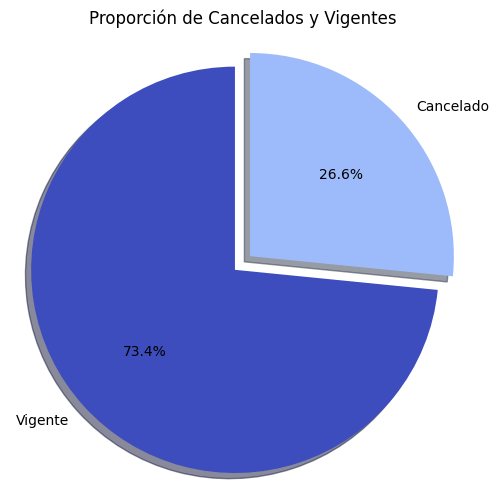

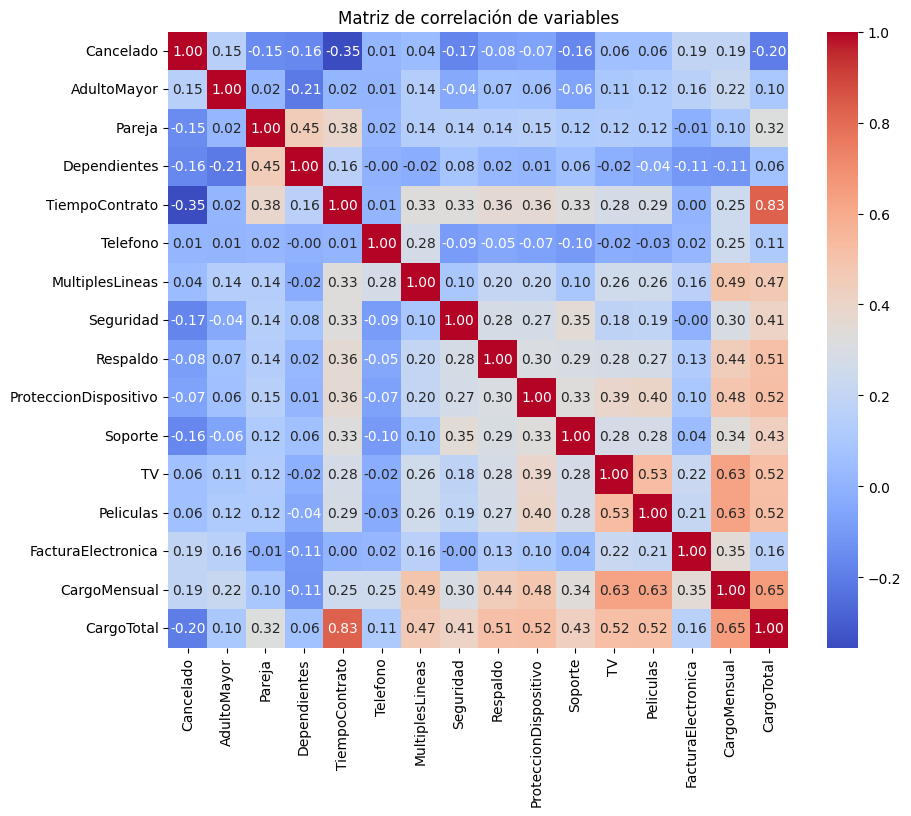


🔍 Análisis de correlación:
Cancelado                1.000000
TiempoContrato           0.354049
CargoTotal               0.199484
CargoMensual             0.192858
FacturaElectronica       0.191454
Seguridad                0.171270
Soporte                  0.164716
Dependientes             0.163128
AdultoMayor              0.150541
Pareja                   0.149982
Respaldo                 0.082307
ProteccionDispositivo    0.066193
TV                       0.063254
Peliculas                0.060860
MultiplesLineas          0.040033
Telefono                 0.011691
Name: Cancelado, dtype: float64




In [12]:
# ===============================
# 🔹 Análisis inicial
# ===============================

# Proporción de cancelados y no cancelados
proporcion = datos["Cancelado"].value_counts(normalize=True)
print("\nProporción de cancelados y vigentes:")
print(proporcion)

# Guardar gráfico de proporción
labels = ['Vigente', 'Cancelado']
colors = ['#3d4dbd', '#9dbbfa']
explode = [0.1, 0]
plt.figure(figsize=(6, 6))
plt.pie(proporcion, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title("Proporción de Cancelados y Vigentes")
plt.axis('equal')
plt.savefig("resultados/graficas/proporcion_cancelados.png", bbox_inches="tight")
plt.show()
plt.close()
print()

# Matriz de correlación
plt.figure(figsize=(10, 8))
correlacion = datos.corr(numeric_only=True)
sns.heatmap(correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de variables")
plt.savefig("resultados/graficas/matriz_correlacion.png", bbox_inches="tight")
plt.show()
plt.close()


# Análisis textual de correlación
print("\n🔍 Análisis de correlación:")
top_corr = correlacion['Cancelado'].abs().sort_values(ascending=False)
print(top_corr)
print("\n")

Se puede observar qur la tasa de cancelaciones es del 26.6%, más de un cuarto de los clientes de Telecom X.  
La antiguedad (TiempoContrato) es uno de los factores más influyentes en las cancelaciones es decir, quienes tienen menos tiempo con la compañía tienden a cancelar con mayor frecuencia.  Otro factor influyente son quienes tienen altos cargos mensuales.

### 3. Análisis dirigido

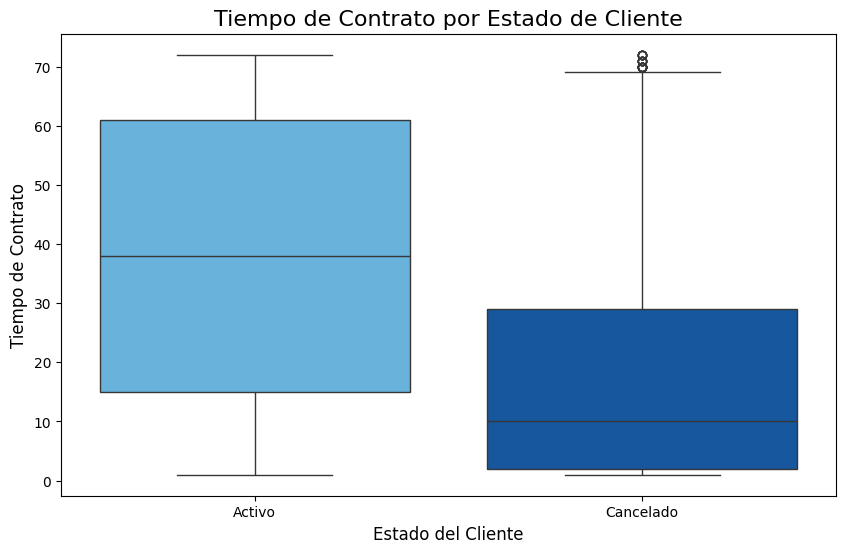

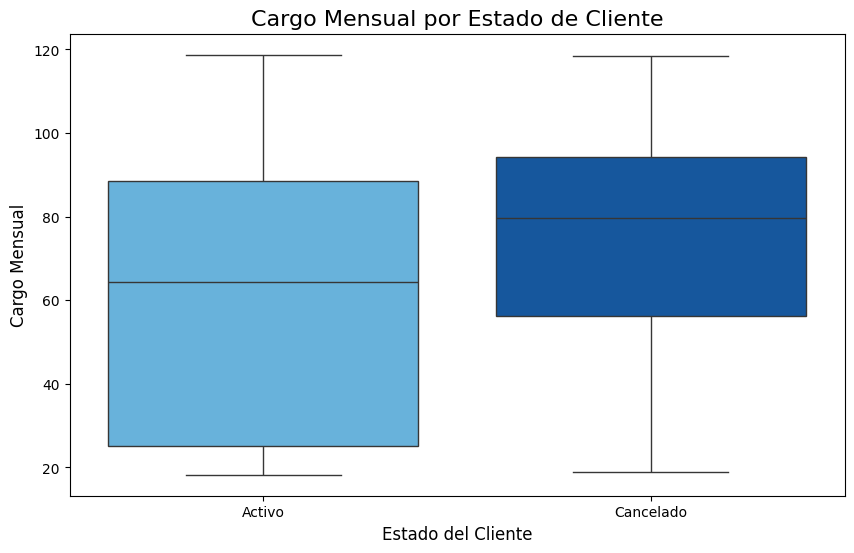

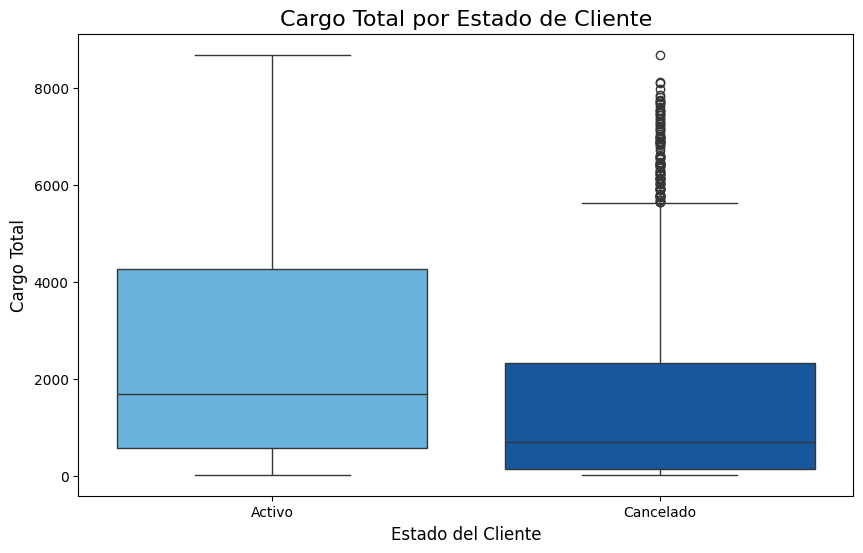

In [13]:
# Renombrar la variable 'Cancelado' para los gráficos
df_plot = datos.copy()
df_plot['Estado'] = df_plot['Cancelado'].apply(lambda x: 'Cancelado' if x == 1 else 'Activo')

# Crear la figura y los subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplot de TiempoContrato por estado de cancelación
sns.boxplot(x='Estado', y='TiempoContrato', data=df_plot, palette=['#55B8EE', '#0056B3'], ax=ax)
ax.set_title('Tiempo de Contrato por Estado de Cliente', fontsize=16)
ax.set_xlabel('Estado del Cliente', fontsize=12)
ax.set_ylabel('Tiempo de Contrato', fontsize=12)
plt.show()
print()

# Boxplot de CargoMensual por estado de cancelación
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Estado', y='CargoMensual', data=df_plot, palette=['#55B8EE', '#0056B3'], ax=ax)
ax.set_title('Cargo Mensual por Estado de Cliente', fontsize=16)
ax.set_xlabel('Estado del Cliente', fontsize=12)
ax.set_ylabel('Cargo Mensual', fontsize=12)
plt.show()
print()

# Boxplot de CargoTotal por estado de cancelación
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Estado', y='CargoTotal', data=df_plot, palette=['#55B8EE', '#0056B3'], ax=ax)
ax.set_title('Cargo Total por Estado de Cliente', fontsize=16)
ax.set_xlabel('Estado del Cliente', fontsize=12)
ax.set_ylabel('Cargo Total', fontsize=12)
plt.show()

En los gráficas se puede apreciar lo siguiente:

1. A menor tiempo con la empresa mayor es la probabilidad de cancelar.
2. Quienes pagan más tienden a cancelar más.
3. Con respecto de los cargos totales, la tendencia a cancelar se puede dar por clientes con cargos mensuales altos y poco tiempo con la empresa o clientes con cargos mensuales bajos y mucho tiempo con la empresa

En resumen, el mayor riesgo de cancelación está tanto en los clientes nuevos con poca antiguedad y que tienen cargos mensuales altos, es decir, la empresa podría estar atrayendo a clientes de alto valor pero falla en la retención talvez la calidad en el servicio recibido por parte del cliente no compensa los altos costos.

### 4. Separación de datos y Encoding

Para realizar el OneHotEncoding se usarán dos formas diferentes para los datos entrenamiento teniendo en cuenta que para los modelos de regresión son sensibles a la colinelidad.


In [14]:
# ======================
# 🔹 Separar variables predictoras y objetivo
# ======================
X = datos.drop("Cancelado", axis=1)
y = datos["Cancelado"]

# Identificar columnas categóricas y numéricas
categoricas = X.select_dtypes(include=["object", "category"]).columns.tolist()
numericas = X.select_dtypes(include=['int64', 'float64']).columns
binarias = [col for col in numericas if X[col].nunique() == 2]
no_binarias = list(set(numericas) - set(binarias))

# ==========================
# 🔹 Codificación One-Hot y Escalado
# ==========================
# Preprocesamiento para Regresión Logística (drop='first' para evitar multicolinealidad)
preprocesador_rl = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categoricas),
        ('num', StandardScaler(), no_binarias)], remainder='passthrough')

# Preprocesamiento para Random Forest y XGBoost (drop=None)
preprocesador_rf_xgb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categoricas),
        ('num', StandardScaler(), no_binarias)], remainder='passthrough')

# ==========================
# 🔹 Separar en train/test
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### 5. Entrenamiento y evaluación de modelos

Se utilizaránn los modelos de Regresión logística, Ramdon Forest y XGBoost.


Entrenando Modelo Regresión Logística...


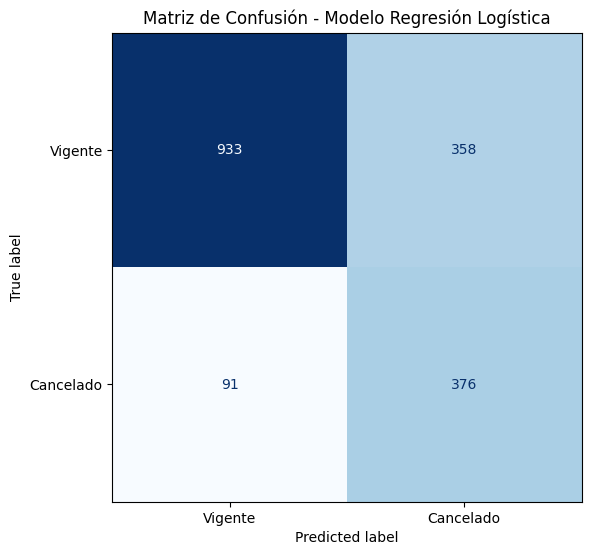

Calculando importancia de variables...

Valores de la Valor del Coeficiente para Modelo Regresión Logística:

                                   Variable  Valor del Coeficiente
1                 cat__Internet_Fiber optic               1.033391
10                          num__CargoTotal               0.744305
22            remainder__FacturaElectronica               0.436151
6          cat__MetodoPago_Electronic check               0.419976
20                            remainder__TV               0.349833
21                     remainder__Peliculas               0.303147
15               remainder__MultiplesLineas               0.238269
11                   remainder__AdultoMayor               0.130755
0                         cat__Genero_Mujer               0.079357
7              cat__MetodoPago_Mailed check               0.070657
18         remainder__ProteccionDispositivo               0.005182
12                        remainder__Pareja              -0.043501
17                 

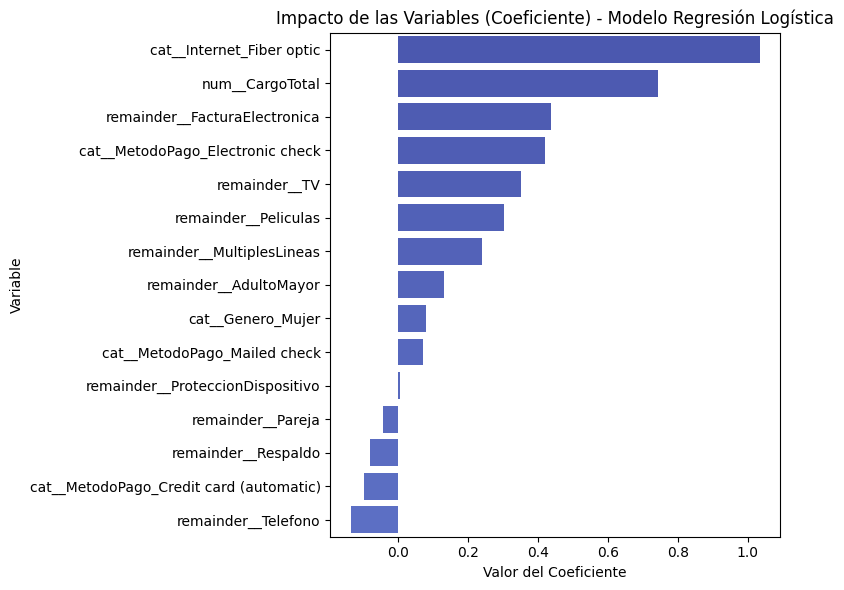


Entrenando Modelo Random Forest...


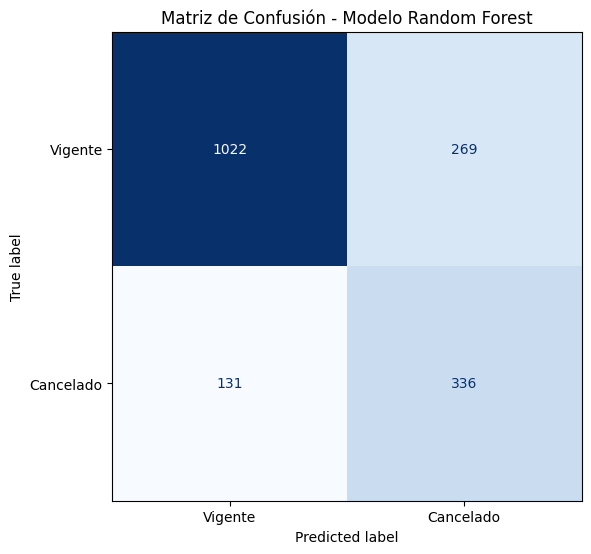

Calculando importancia de variables...

Valores de la Importancia para Modelo Random Forest:

                            Variable  Importancia
5       cat__Contrato_Month-to-month     0.158960
12               num__TiempoContrato     0.124235
13                 num__CargoMensual     0.079611
7             cat__Contrato_Two year     0.078404
14                   num__CargoTotal     0.077963
3          cat__Internet_Fiber optic     0.057472
10  cat__MetodoPago_Electronic check     0.053553
20              remainder__Seguridad     0.044330
26     remainder__FacturaElectronica     0.044247
23                remainder__Soporte     0.036740
6             cat__Contrato_One year     0.029841
4                   cat__Internet_No     0.026358
16                 remainder__Pareja     0.021577
17           remainder__Dependientes     0.018843
24                     remainder__TV     0.016202



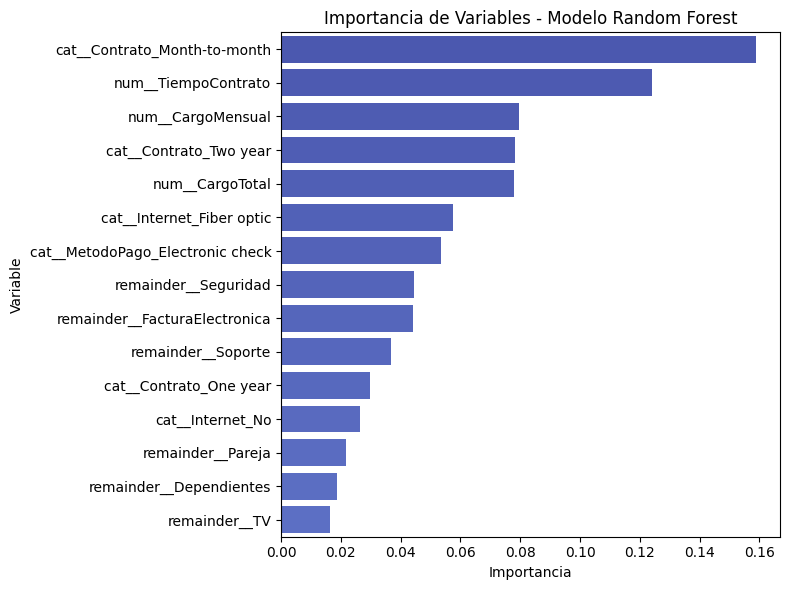


Entrenando Modelo XGBoost...


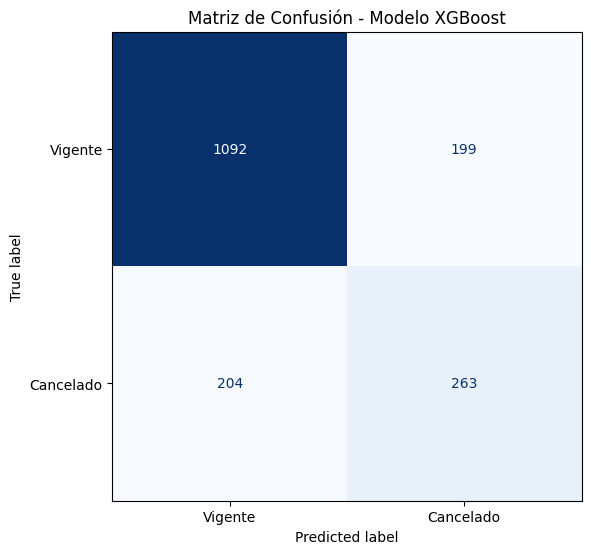

Calculando importancia de variables...

Valores de la Importancia para Modelo XGBoost:

                         Variable  Importancia
5    cat__Contrato_Month-to-month     0.374434
3       cat__Internet_Fiber optic     0.182599
24                  remainder__TV     0.035385
20           remainder__Seguridad     0.030849
23             remainder__Soporte     0.027736
25           remainder__Peliculas     0.027146
26  remainder__FacturaElectronica     0.026743
19     remainder__MultiplesLineas     0.024764
4                cat__Internet_No     0.023710
7          cat__Contrato_Two year     0.021668
16              remainder__Pareja     0.021133
2               cat__Internet_DSL     0.019825
6          cat__Contrato_One year     0.019398
18            remainder__Telefono     0.018401
21            remainder__Respaldo     0.018364



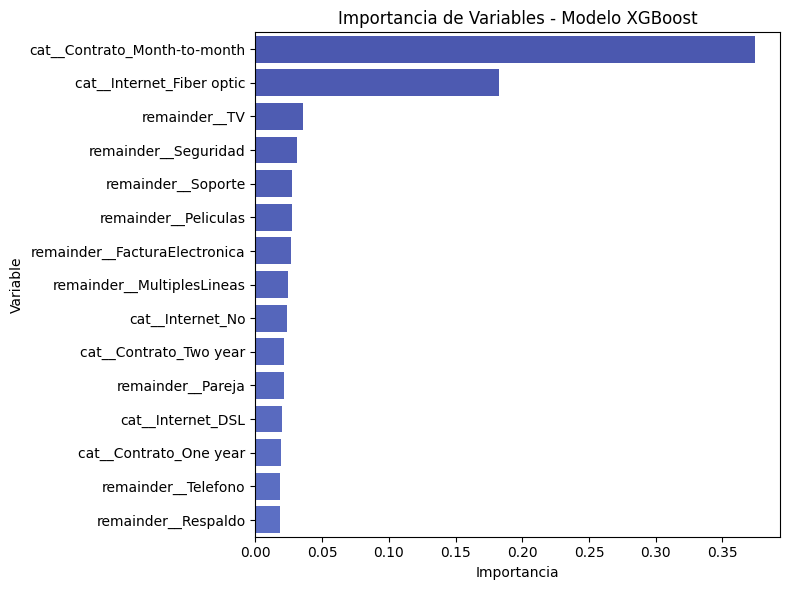

In [15]:
# ================================================
# 🔹 ENTRENAMIENTO Y EVALUACIÓN DE MODELOS
# ================================================
# Se ha refactorizado la función para usar imblearn.pipeline.Pipeline,
# lo que integra SMOTE de forma segura y correcta.

# Listas y diccionarios para guardar resultados
resultados_modelos = []
curvas_roc = {}

def entrenar_y_evaluar(nombre_modelo, pipeline_con_smote, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo utilizando un pipeline que incluye SMOTE.
    """
    print(f"Entrenando {nombre_modelo}...")
    pipeline_con_smote.fit(X_train, y_train)
    y_pred = pipeline_con_smote.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Probabilidades para ROC y AUC
    y_prob = pipeline_con_smote.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)

    # Guardar resultados en la lista
    resultados_modelos.append({
        "Modelo": nombre_modelo,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "roc_auc": roc_auc
    })

    # --- Matriz de Confusión ---
    cm = confusion_matrix(y_test, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Vigente", "Cancelado"])
    disp.plot(ax=ax_cm, cmap="Blues", values_format='d', colorbar=False)
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.tight_layout()
    plt.savefig(f"resultados/graficas/matriz_confusion_{nombre_modelo}.png", dpi=300)
    plt.show()
    plt.close(fig_cm)

    # --- Curva ROC ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    curvas_roc[nombre_modelo] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    # --- Importancia de variables / Coeficientes ---
    try:
        print('Calculando importancia de variables...')
        modelo_entrenado = pipeline_con_smote.named_steps['modelo']
        nombres_vars = pipeline_con_smote.named_steps['preprocesador'].get_feature_names_out()

        # Determinar si el modelo usa feature_importances_ o coef_
        if hasattr(modelo_entrenado, "feature_importances_"):
            importancias = modelo_entrenado.feature_importances_
            col_name = "Importancia"
            title_text = "Importancia de Variables"
        elif hasattr(modelo_entrenado, "coef_"):
            importancias = modelo_entrenado.coef_[0]
            col_name = "Valor del Coeficiente"
            title_text = "Impacto de las Variables (Coeficiente)"
            ascending_order = False
        else:
            importancias = None

        if importancias is not None:
            df_importancia = pd.DataFrame({
                "Variable": nombres_vars,
                col_name: importancias
            }).sort_values(by=col_name, ascending=False)

            # IMPRIMIR LOS VALORES ANTES DE GRAFICAR
            print(f"\nValores de la {col_name} para {nombre_modelo}:\n")
            print(df_importancia.head(15)) # Imprimir las top 15
            print()

            df_importancia.to_csv(f"resultados/metricas/importancia_variables_{nombre_modelo}.csv", index=False)
            fig_imp, ax_imp = plt.subplots(figsize=(8, 6))
            palette = sns.color_palette("coolwarm", n_colors=256)
            sns.barplot(x=col_name, y="Variable", data=df_importancia.head(15), palette=palette)
            ax_imp.set_title(f"{title_text} - {nombre_modelo}")
            plt.tight_layout()
            plt.savefig(f"resultados/graficas/importancia_variables_{nombre_modelo}.png", dpi=300)
            plt.show()
            plt.close(fig_imp)
            print()
    except Exception as e:
        print(f"⚠ No se pudo calcular la importancia de variables para {nombre_modelo}: {e}")

    # Guardar pipeline completo
    joblib.dump(pipeline_con_smote, f"resultados/modelos/{nombre_modelo}.pkl")

    # return roc_auc

# === Definición de Pipelines con imblearn ===
pipeline_rl_imb = ImbPipeline(steps=[
    ('preprocesador', preprocesador_rl),
    ('smote', SMOTE(random_state=42)),
    ('modelo', LogisticRegression(max_iter=1000, random_state=42))])

pipeline_rf_imb = ImbPipeline(steps=[
    ('preprocesador', preprocesador_rf_xgb),
    ('smote', SMOTE(random_state=42)),
    ('modelo', RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42))])

pipeline_xgb_imb = ImbPipeline(steps=[
    ('preprocesador', preprocesador_rf_xgb),
    ('smote', SMOTE(random_state=42)),
    ('modelo', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Entrenar y evaluar modelos
entrenar_y_evaluar("Modelo Regresión Logística", pipeline_rl_imb, X_train, y_train, X_test, y_test)
entrenar_y_evaluar("Modelo Random Forest", pipeline_rf_imb, X_train, y_train, X_test, y_test)
entrenar_y_evaluar("Modelo XGBoost", pipeline_xgb_imb, X_train, y_train, X_test, y_test)


** 🧠Análisis de la Importancia de Variables ***

Comparando los resultados arrojados por los 3 modelos en cuanto a importacia de variables, se puede identificar los factores que influyen de forma más determinante en la cancelación:

1. Tipo de Contrato mes a mes: Esta variable es la más determinante en todos los modelos, especialmente en XGBoost (0.368) y Random Forest (0.157). La falta de compromiso a largo plazo aumenta la probabilidad de que un cliente cancele.

2. Servicio de Internet de fibra óptica: Esta variable tiene una importancia consistentemente alta, especialmente en la Regresión Logística (coeficiente de 1.035) y en XGBoost (0.189). Esto indica que existe un problema con la satisfacción de los clientes de este servicio.

3. Cargos y Pagos: Los cargos totales y los pagos en cheque electrónico también tienen un impacto significativo. Un alto cargo total y el uso de cheques electrónicos son indicadores de un perfil de cliente más propenso a cancelar.


📊 Comparativa de Modelos:



,Modelo,Accuracy,Precision,Recall,F1-Score,roc_auc
0,Modelo Regresión Logística,0.744596,0.512262,0.805139,0.626145,0.843278
1,Modelo Random Forest,0.772469,0.555372,0.719486,0.626866,0.841456
2,Modelo XGBoost,0.770762,0.569264,0.563169,0.566200,0.814769


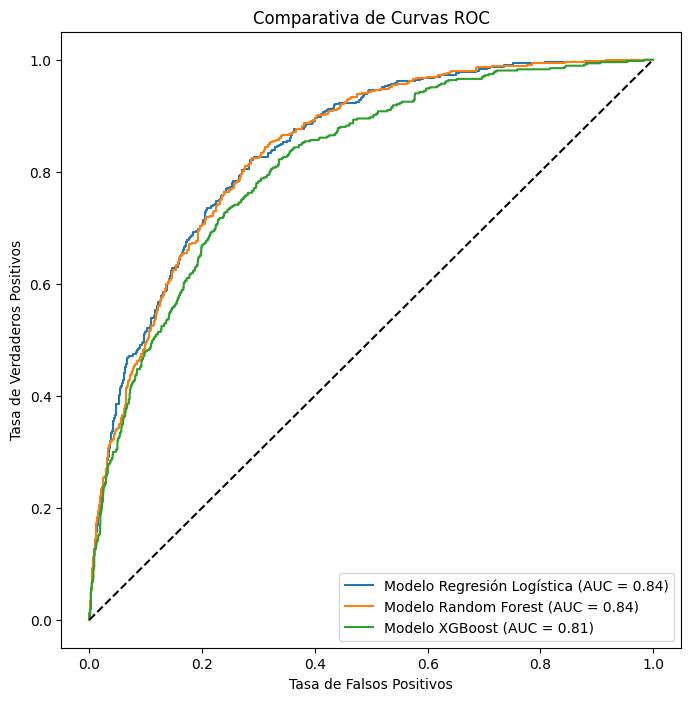

In [16]:
# === Mostrar y guardar resultados ===

def mostrar_resultados():
    """Muestra y guarda los resultados comparativos de los modelos."""
    df_resultados = pd.DataFrame(resultados_modelos)
    print("\n📊 Comparativa de Modelos:\n")
    display(df_resultados)
    df_resultados.to_csv("resultados/metricas/metricas_modelos.csv", index=False)
    print()

    # Gráfico comparativo de curvas ROC
    plt.figure(figsize=(8, 8))
    for nombre, curva in curvas_roc.items():
        plt.plot(curva['fpr'], curva['tpr'], label=f"{nombre} (AUC = {curva['auc']:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title("Comparativa de Curvas ROC")
    plt.legend(loc="lower right")
    plt.savefig("resultados/graficas/comparativa_roc.png", dpi=300)
    plt.show()
    plt.close()


mostrar_resultados()

*** Selección del mejor modelo ***

De acuerdo a los resultados obtenidos, de los tres modelos evaluados, quienes tienen mejores métricas en cuanto a Recall, F1-score y AUC-ROC, son el Random Forest y la Regresión Logística, no obstante aunque el modelo de Regresión tiene los Recall y AUC-ROC más altos de todos los modelos evaluados, el Random Forest tiene mayor precisión y exactitud que éste último, lo que lo hace el más confiable y capaz para detectar clientes que podrían cancelar.
Por lo tanto, se elige al modelo Random Forest como el mejor para predecir la cancelación de clientes.


### 6. Almacenamiento del mejor modelo predicitvo para Churn de clientes

Con base en el análisis realizado en el punto anterior, se elige una métrica que lo haga único (F1-Score) para guardarlo.

In [17]:
# ================================================
# 🔹 GUARDAR MEJOR MODELO COMO 'mejor_modelo.pkl'
# ================================================
# Cargar los pipelines guardados para determinar cuál es el mejor
pipeline_log_cargado = joblib.load("resultados/modelos/Modelo Regresión Logística.pkl")
pipeline_rf_cargado = joblib.load("resultados/modelos/Modelo Random Forest.pkl")
pipeline_xgb_cargado = joblib.load("resultados/modelos/Modelo XGBoost.pkl") # <<<<<< NUEVO

# Obtener las métricas de los resultados_modelos list para comparar
df_resultados_final = pd.DataFrame(resultados_modelos)

# Determinar cuál modelo tiene el mejor ROC-AUC
mejor_modelo_nombre = df_resultados_final.loc[df_resultados_final['F1-Score'].idxmax(), 'Modelo']
print(f"\n🏆 El mejor modelo, basado en el F1-Score, es: {mejor_modelo_nombre}")

# Cargar el mejor modelo y guardarlo con un nombre genérico
mejor_pipeline = joblib.load(f"resultados/modelos/{mejor_modelo_nombre}.pkl")
joblib.dump(mejor_pipeline, "resultados/modelos/mejor_modelo.pkl")
print(f"El mejor modelo ('{mejor_modelo_nombre}') ha sido guardado como 'mejor_modelo.pkl'.")


🏆 El mejor modelo, basado en el F1-Score, es: Modelo Random Forest
El mejor modelo ('Modelo Random Forest') ha sido guardado como 'mejor_modelo.pkl'.
